In [78]:
import numpy as np 
import pandas as pd 
import pickle

import torch 
import torch.nn as nn 
import torch.optim as optim
from sklearn.manifold import MDS

from tqdm import tqdm

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
sys.path.append('..')

from utils.viz import viz 
from utils.env_fn import gauss_blob_task
from utils.model import MLP
from utils.analysis import rotate
viz.get_style()

In [79]:
env  = gauss_blob_task()
x, y = gauss_blob_task().instan()

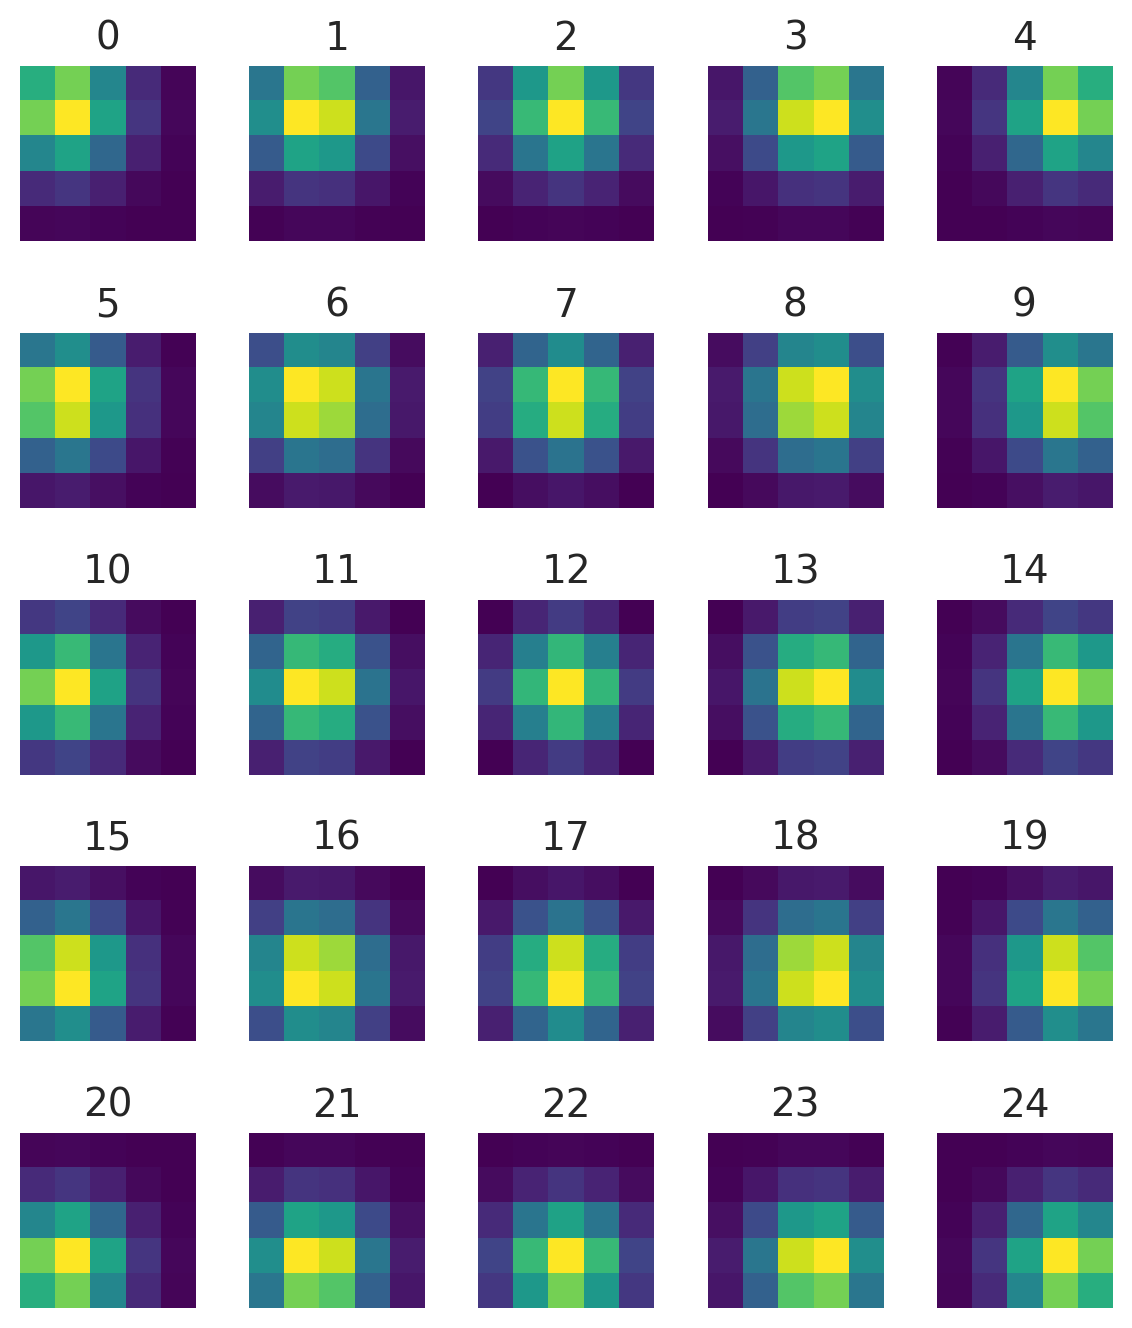

In [4]:
fig, axs = plt.subplots(5, 5, figsize=(6, 7))
for i in range(env.S.shape[0]):

    ax = axs[i//5, i%5]
    z = env.S[i, :, :]
    # Visualize the Gaussian blob
    ax.imshow(z, cmap='viridis', interpolation='none', extent=[-2, 2, -2, 2])
    ax.set_title(f'{i}', fontsize=14)
    ax.set_axis_off()
fig.tight_layout()

# Analyze

In [80]:
with open('../data/weights_lr=.005.pkl', 'rb')as handle:
    weights = pickle.load(handle)

In [81]:
w_data = {'var': [], 'val': [], 'samp_id': [], 'sig': []}
for sig in [.01, .4, 3.]:
    # add w1 
    w_data['val'] += [np.linalg.norm(w.reshape([-1])) for w in weights[sig]['w1']]
    w_data['var'] += len(weights[sig]['w1'])*['w1']
    w_data['samp_id'] += list(range(len(weights[sig]['w1'])))
    w_data['sig'] += len(weights[sig]['w1'])*[sig]
    # add w2 
    w_data['val'] += [np.linalg.norm(w.reshape([-1])) for w in weights[sig]['w2']]
    w_data['var'] += len(weights[sig]['w2'])*['w2']
    w_data['samp_id'] += list(range(len(weights[sig]['w2'])))
    w_data['sig'] += len(weights[sig]['w2'])*[sig]
    # delta w1
    w_data['val'] += [np.log(np.linalg.norm(w.reshape([-1])-w0.reshape([-1]))
        ) for w, w0 in zip(weights[sig]['w1'], weights[sig]['w1_init'])]
    w_data['var'] += len(weights[sig]['w1'])*['delta_w1']
    w_data['samp_id'] += list(range(len(weights[sig]['w1'])))
    w_data['sig'] += len(weights[sig]['w1'])*[sig]
    # delta w2
    w_data['val'] += [np.log(np.linalg.norm(w.reshape([-1])-w0.reshape([-1]))
        ) for w, w0 in zip(weights[sig]['w2'], weights[sig]['w2_init'])]
    w_data['var'] += len(weights[sig]['w2'])*['delta_w2']
    w_data['samp_id'] += list(range(len(weights[sig]['w2'])))
    w_data['sig'] += len(weights[sig]['w2'])*[sig]
w_data = pd.DataFrame.from_dict(w_data)

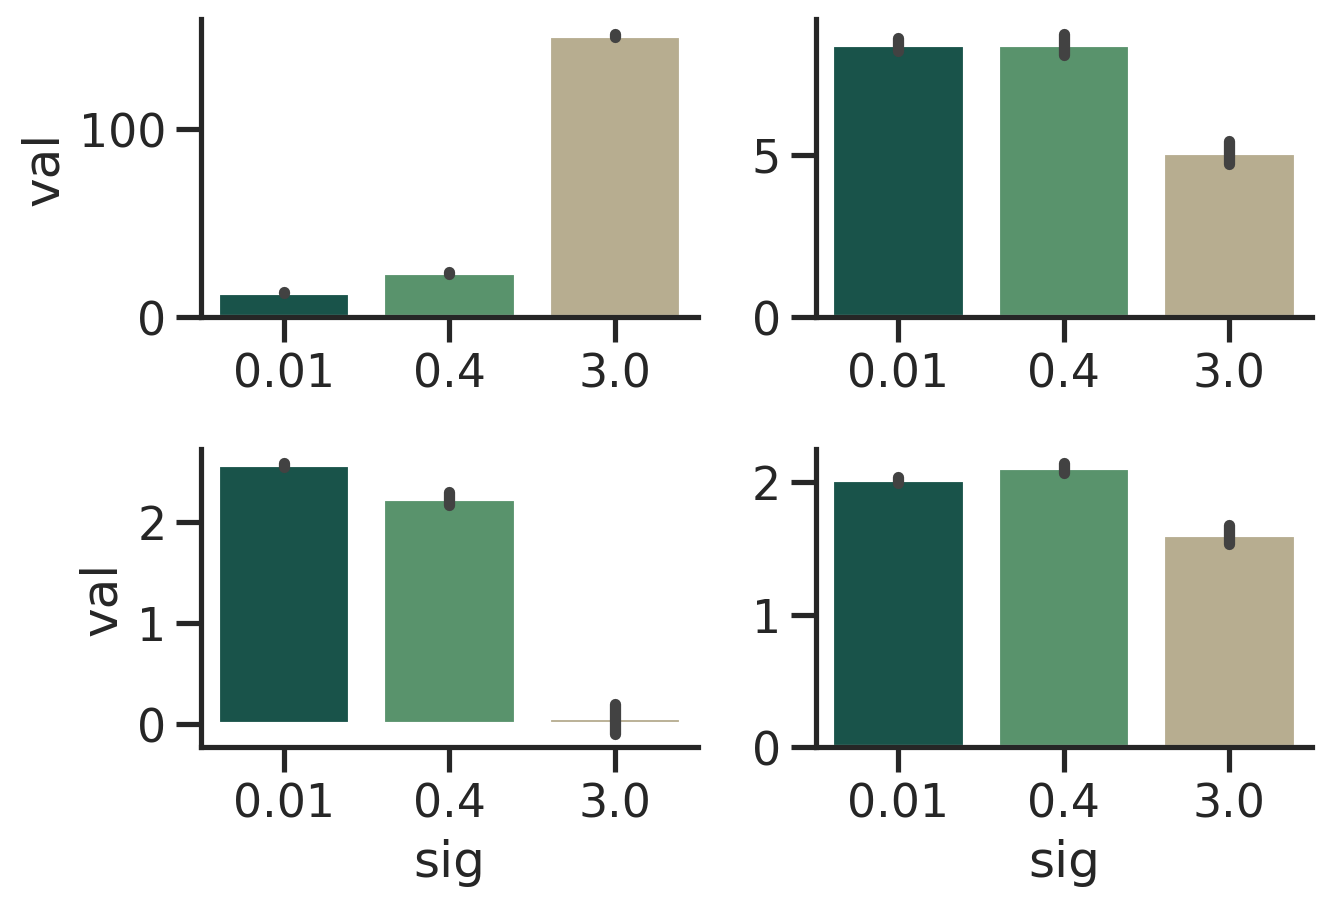

In [82]:
fig, axs = plt.subplots(2, 2, figsize=(7, 5))
w_vars = ['w1', 'w2', 'delta_w1', 'delta_w2']
for i, w_var in enumerate(w_vars):
    ax = axs[i//2, i%2]
    sel_data = w_data.query(f'var=="{w_var}"')
    sns.barplot(x='sig', y='val', data=sel_data, 
                palette=viz.Pal_type,
                ax=ax)
    ax.set_box_aspect(.6)
    if i//2==0: ax.set_xlabel('')
    if i%2==1:  ax.set_ylabel('')
fig.tight_layout()

In [83]:
class net(nn.Module):
    def __init__(self, sig_w=.1):
        super().__init__()
        self.fc1 = nn.Linear(27, 100)
        self.fc2 = nn.Linear(100, 1)
        with torch.no_grad():
            w_fc1 = torch.hstack([sig_w*torch.randn([100, 25]), 
                                  sig_w*torch.randn([100, 2])])
            #w_fc1 = torch.FloatTensor(w1)
            self.fc1.weight.copy_(w_fc1)
            self.fc1.bias.fill_(0)
            self.fc2.weight.copy_(.1*torch.randn([1, 100]))
            self.fc2.bias.fill_(0)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [204]:
sig_w = 3
sig_c = 1.5
i = 0 
z_all = 0
env  = gauss_blob_task()
x, y = gauss_blob_task().instan()
for i in range(len(weights[sig_w]['param'])):
    model = MLP(25, 2, 100, 1, .001, sig_w, sig_c, .1)
    model.w_hxs = weights[sig_w]['param'][i]['w1'][:, :25]
    model.w_hxc = weights[sig_w]['param'][i]['w1'][:, 25:]
    model.b_hx  = weights[sig_w]['param'][i]['b1']
    model.w_yh  = weights[sig_w]['param'][i]['w2']
    model.b_yh  = weights[sig_w]['param'][i]['b2']
    model.fprop(x[:, :25].T, x[:, 25:].T, y.reshape([1, -1]))
    z = model.h_out.T
    z_all += z/len(weights[sig_w]['param'])
embedding = MDS(n_components=3, normalized_stress='auto')
xx = embedding.fit_transform(z_all)

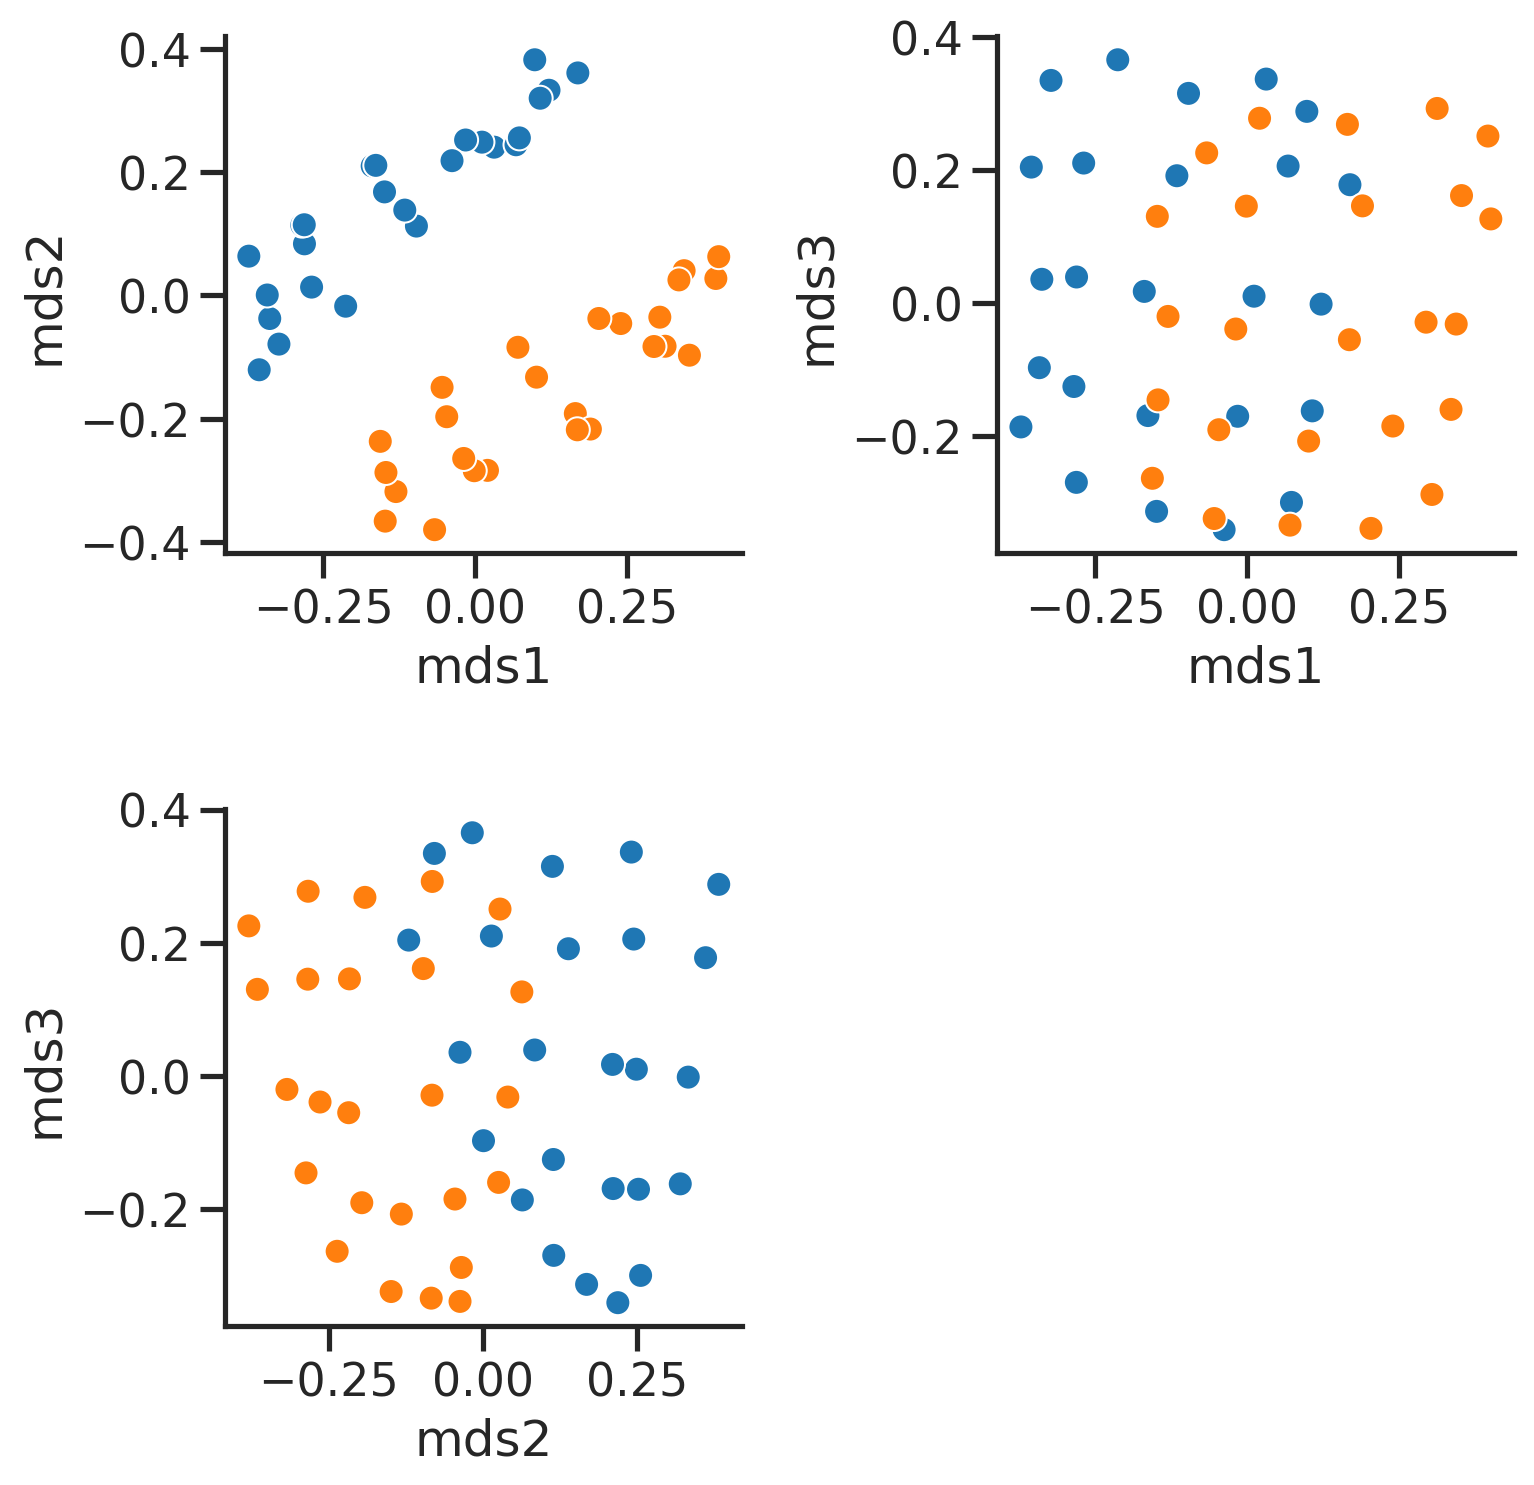

In [211]:
theta_x = 20
theta_y = -10
theta_z = 20

xyz_rot = rotate(xx,theta_x,axis='x')
xyz_rot = rotate(xyz_rot,theta_y,axis='y')
xyz_rot = rotate(xyz_rot,theta_z,axis='z')

x_embed = pd.DataFrame(xyz_rot, columns=['mds1', 'mds2', 'mds3'])
x_embed['task'] = [0]*25+[1]*25

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
dims = [['mds1', 'mds2'],['mds1', 'mds3'],['mds2', 'mds3']]
for i, dim in enumerate(dims):
    ax = axs[i//2, i%2]
    
    sns.scatterplot(x=dim[0], y=dim[1], data=x_embed, 
                    hue='task',
                    ax=ax)
    ax.set_box_aspect(1)
    ax.legend().remove()
axs[1, 1].set_axis_off()
fig.tight_layout()

In [277]:
x = np.vstack([np.array([0]*25+[1]*25),
               np.tile(np.tile(np.linspace(-2, 2, 5), 5), 2),
               np.tile(np.repeat(np.linspace(-2, 2, 5), 5), 2)]).T
x_a = x[:25, :]
x_b = x[25:, :]
y_a = np.array([1, 0, 0, 0, 0, 0, 0, 0, 1]).reshape([-1, 3])
y_b = np.array([1, 0, 0, 0, 1, 0, 0, 0, 0]).reshape([-1, 3])
R_a = np.array([1, 0, 0, 0, np.cos(np.pi/2), np.sin(np.pi/2), 
    0, -np.sin(np.pi/2), np.cos(np.pi/2)]).reshape([-1, 3])
x_grid = np.vstack([x_a, x_b])
x_orth = np.vstack([x_a@y_a, x_b@y_b])
x_parl = np.vstack([(x_a@y_a)@R_a, x_b@y_b]).round(2)
x_rotgrid = np.vstack([x_a@R_a, x_b])
x_branch = np.vstack([x_a@y_a, x_b@y_a])
x_leaf = np.vstack([x_a@y_b, x_b@y_b])

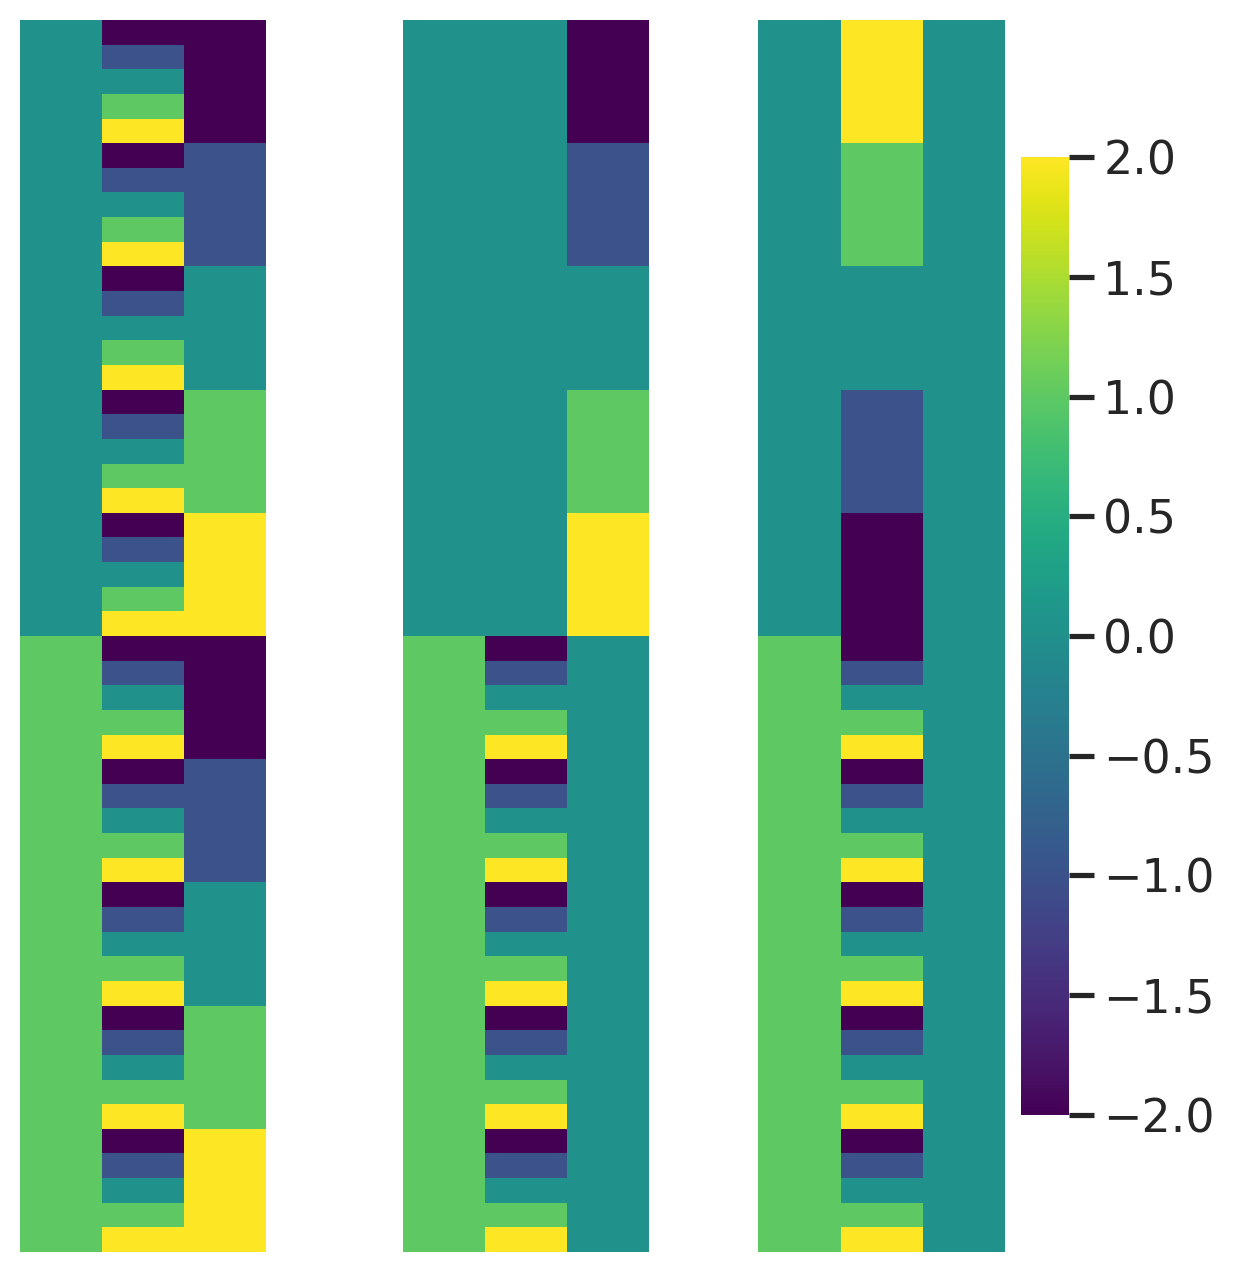

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(7, 8))
for i, x_mat in enumerate([x_grid, x_orth, x_parl]):
    ax = axs[i]
    sns.heatmap(x_mat, ax=ax, cbar=False 
            if i<2 else True, cmap='viridis')
    ax.set_box_aspect(5)
    ax.set_axis_off()

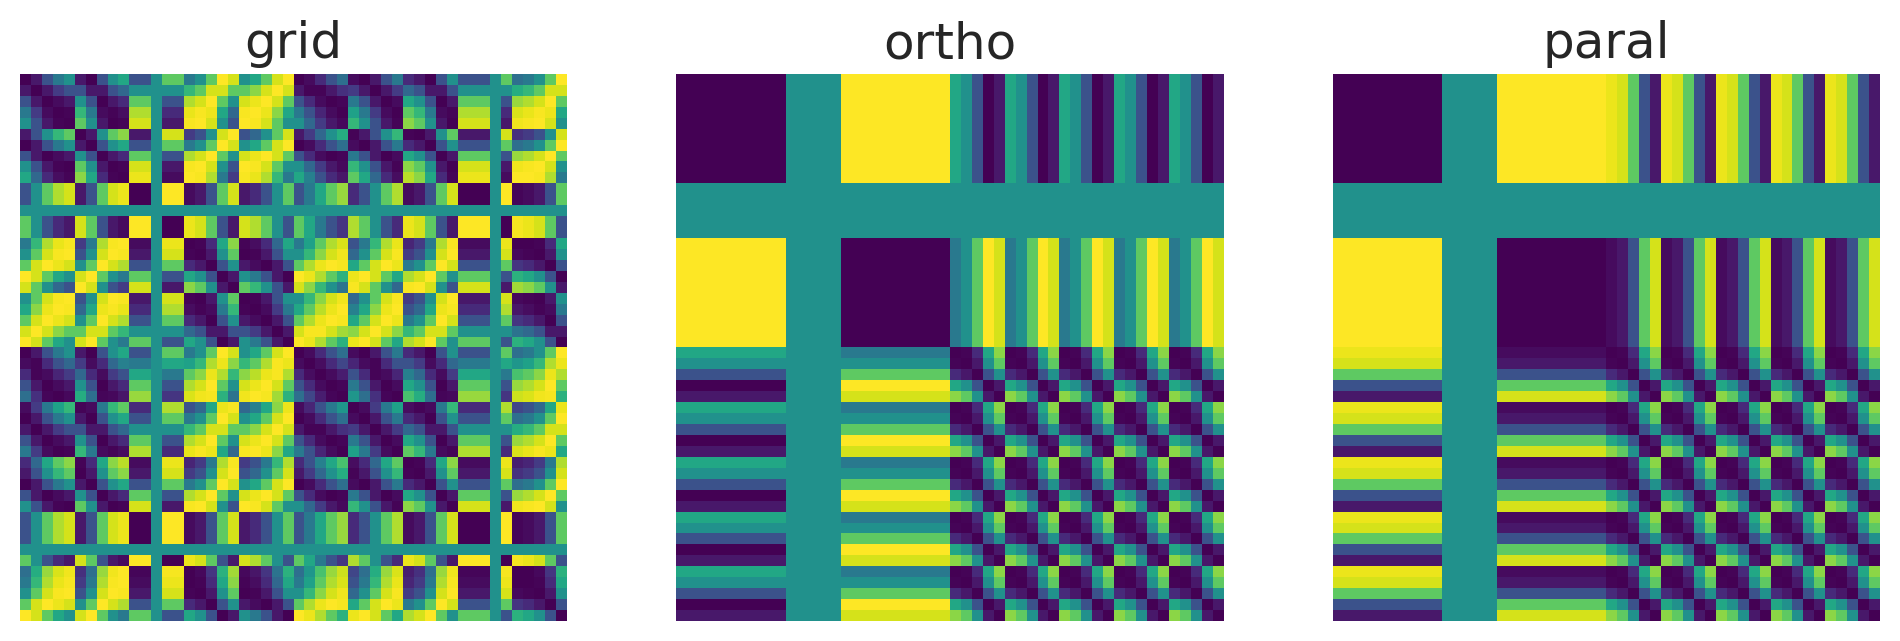

In [17]:
typ = 'grid'
rdms = {}
til = ['grid', 'ortho', 'paral']
for typ in ['grid', 'orth', 'parl']:
    x_bar = eval(f'x_{typ}') - eval(f'x_{typ}').mean(1, keepdims=True)
    rdm = np.zeros([50, 50])
    for i in range(x_bar.shape[0]):
        for j in range(x_bar.shape[0]):
            xi = x_bar[i, :]
            xj = x_bar[j, :]
            d = 1 - (xi@xj.T/np.sqrt(xi@xi.T*xj@xj.T+1e-12))
            rdm[i, j] = d
    rdms[typ] = rdm
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, typ in enumerate(rdms.keys()):
    ax = axs[i]
    sns.heatmap(rdms[typ].round(2), cmap='viridis', 
                vmin=0, vmax=2,
                cbar=None, ax=ax)
    ax.set_box_aspect(1)
    ax.set_title(f'{til[i]}')
    ax.set_axis_off()

In [271]:
embedding = MDS(n_components=3, normalized_stress='auto')
xx = embedding.fit_transform(x_grid)

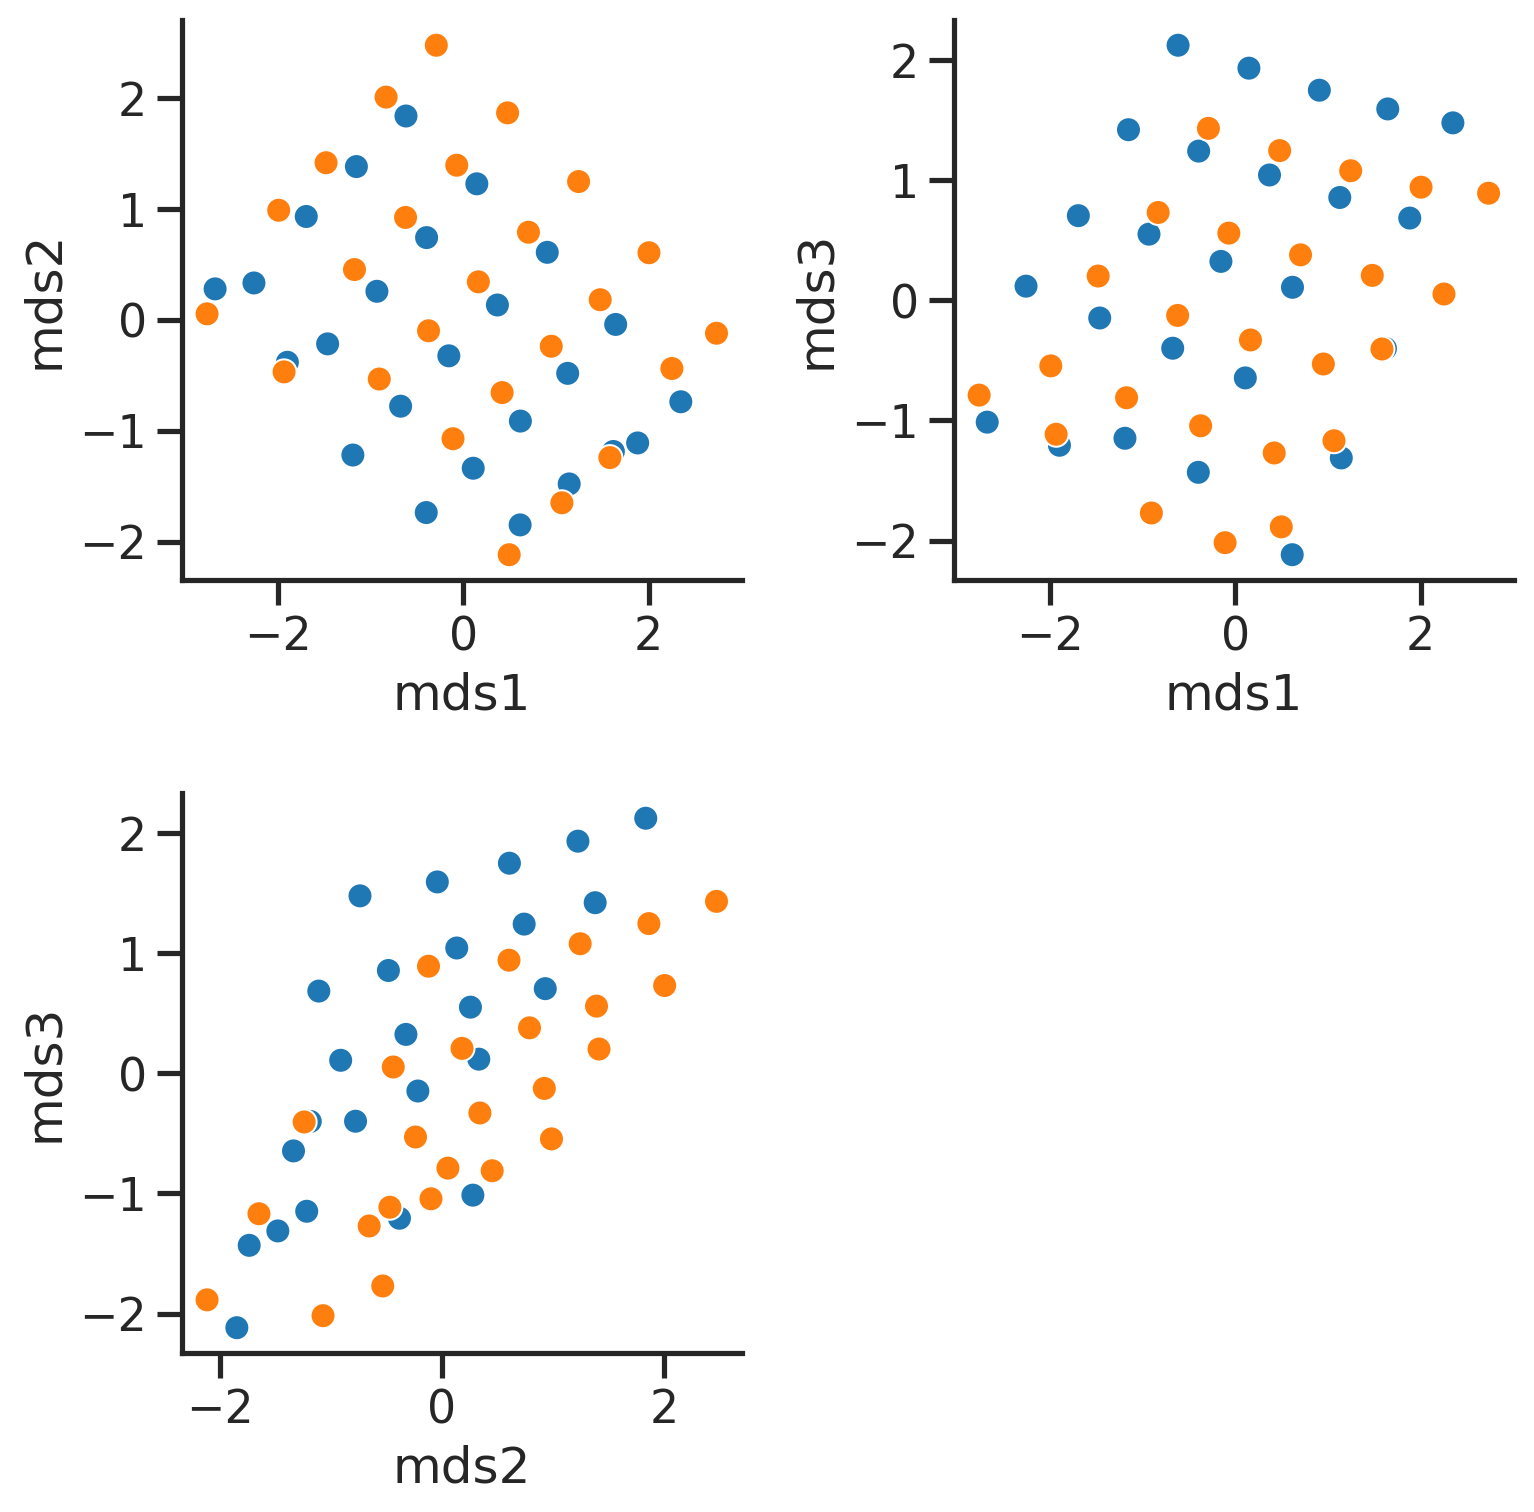

In [275]:
theta_x = 0
theta_y = -7
theta_z = -2

xyz_rot = rotate(xx,theta_x,axis='x')
xyz_rot = rotate(xyz_rot,theta_y,axis='y')
xyz_rot = rotate(xyz_rot,theta_z,axis='z')

x_embed = pd.DataFrame(xyz_rot, columns=['mds1', 'mds2', 'mds3'])
x_embed['task'] = [0]*25+[1]*25

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
dims = [['mds1', 'mds2'],['mds1', 'mds3'],['mds2', 'mds3']]
for i, dim in enumerate(dims):
    ax = axs[i//2, i%2]
    
    sns.scatterplot(x=dim[0], y=dim[1], data=x_embed, 
                    hue='task',
                    ax=ax)
    ax.set_box_aspect(1)
    ax.legend().remove()
axs[1, 1].set_axis_off()
fig.tight_layout()

In [285]:
a = np.zeros([5, 3])
a[:, 2] = [-2, -1, 0, 1, 2]
a

array([[ 0.,  0., -2.],
       [ 0.,  0., -1.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  2.]])

In [268]:
theta = [1.5, .1, .4, np.deg2rad(0)]
x = np.vstack([np.array([0]*25+[1]*25).reshape([-1])*theta[0],
               np.array([(1-theta[1])]*25+[(1-theta[2])]*25
                    )*np.tile(np.tile(np.linspace(-2, 2, 5), 5), 2),
               np.array([(1-theta[2])]*25+[(1-theta[1])]*25
                     )*np.tile(np.repeat(np.linspace(-2, 2, 5), 5), 2)]).T
R_a = np.array([1, 0, 0, 0, np.cos(theta[3]), np.sin(theta[3]), 
    0, -np.sin(theta[3]), np.cos(theta[3])]).reshape([-1, 3])
x_param = np.vstack([x[:25, :]@R_a, x[25:, :]])
embedding = MDS(n_components=3, normalized_stress='auto')
xx = embedding.fit_transform(x_param)

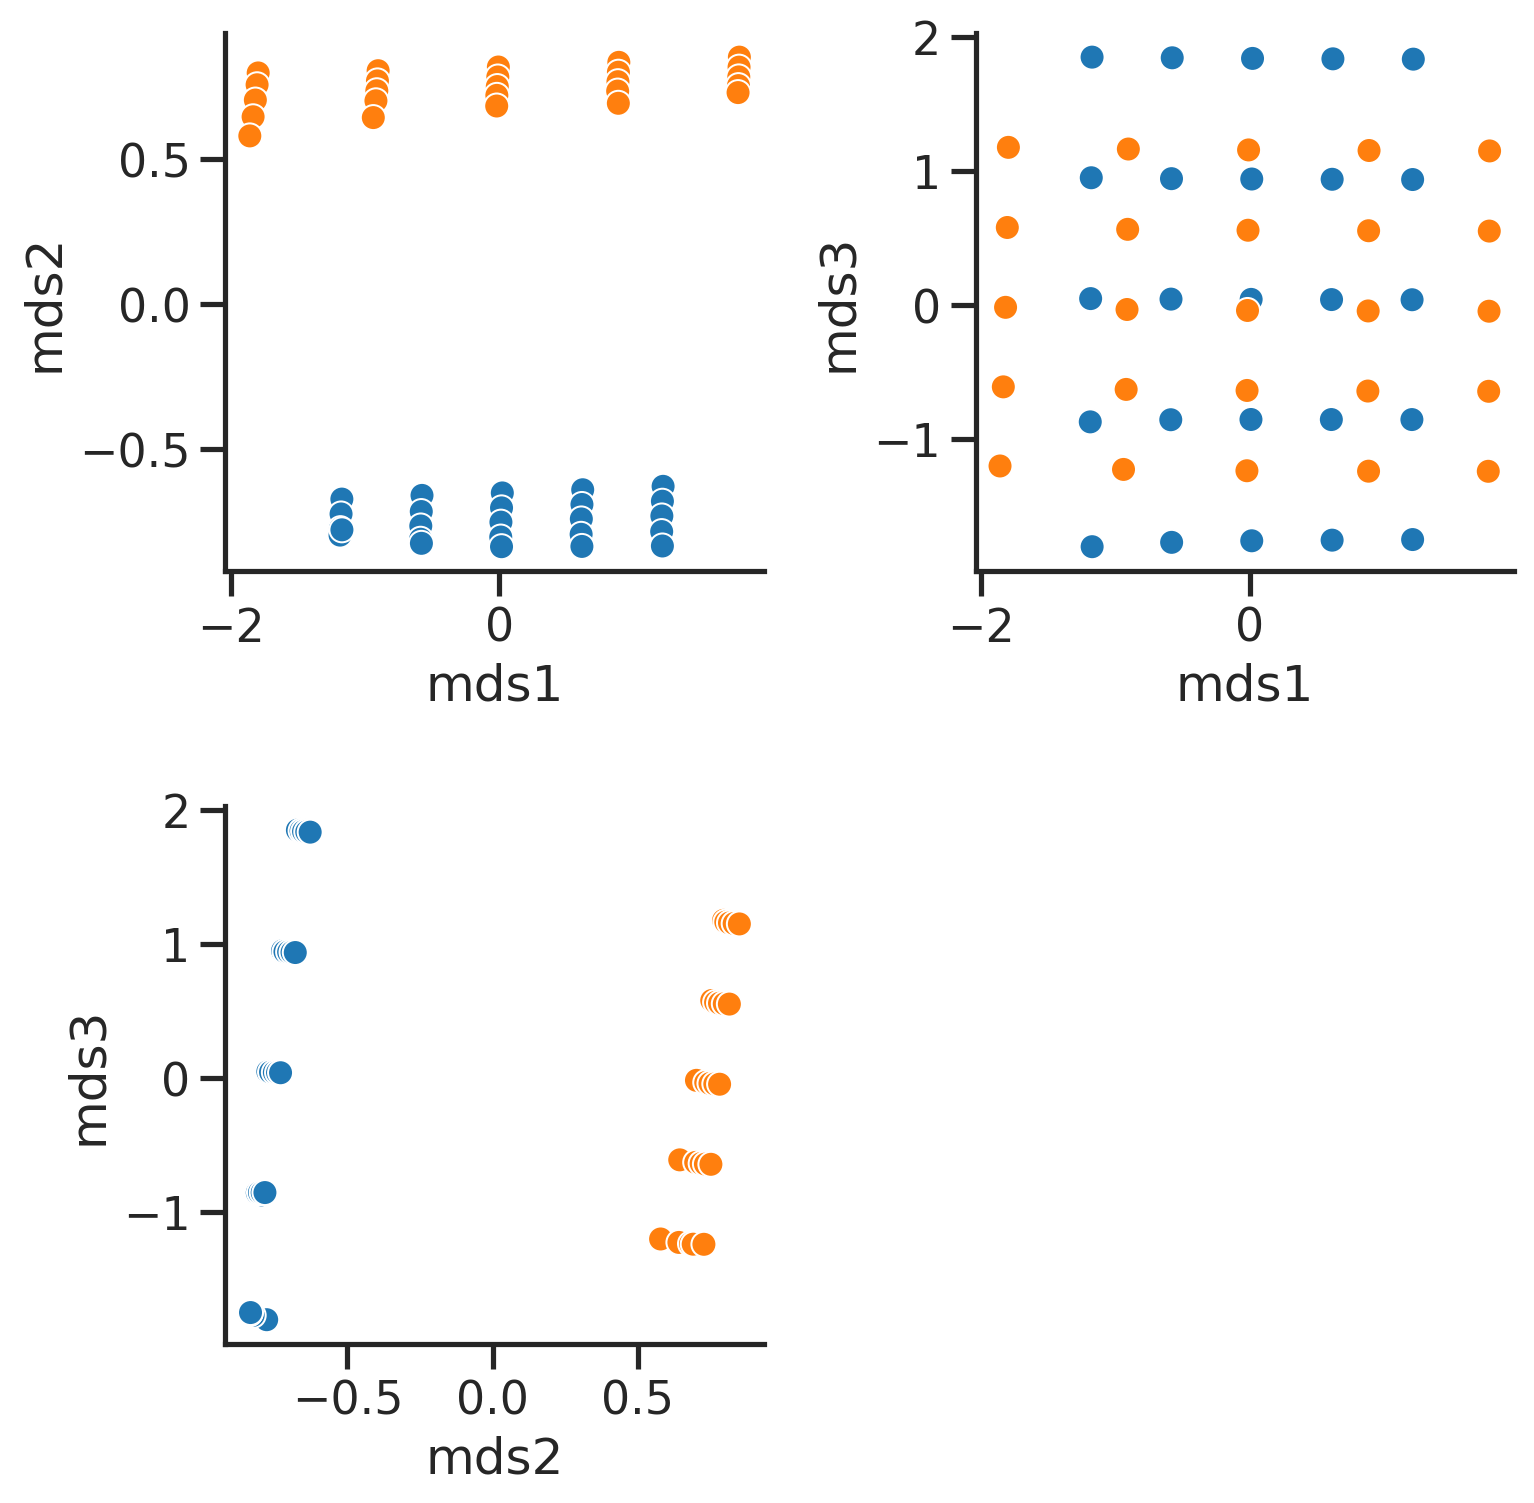

In [269]:
theta_x = 0
theta_y = 0
theta_z = 0

xyz_rot = rotate(xx,theta_x,axis='x')
xyz_rot = rotate(xyz_rot,theta_y,axis='y')
xyz_rot = rotate(xyz_rot,theta_z,axis='z')

x_embed = pd.DataFrame(xyz_rot, columns=['mds1', 'mds2', 'mds3'])
x_embed['task'] = [0]*25+[1]*25

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
dims = [['mds1', 'mds2'],['mds1', 'mds3'],['mds2', 'mds3']]
for i, dim in enumerate(dims):
    ax = axs[i//2, i%2]
    
    sns.scatterplot(x=dim[0], y=dim[1], data=x_embed, 
                    hue='task',
                    ax=ax)
    ax.set_box_aspect(1)
    ax.legend().remove()
axs[1, 1].set_axis_off()
fig.tight_layout()

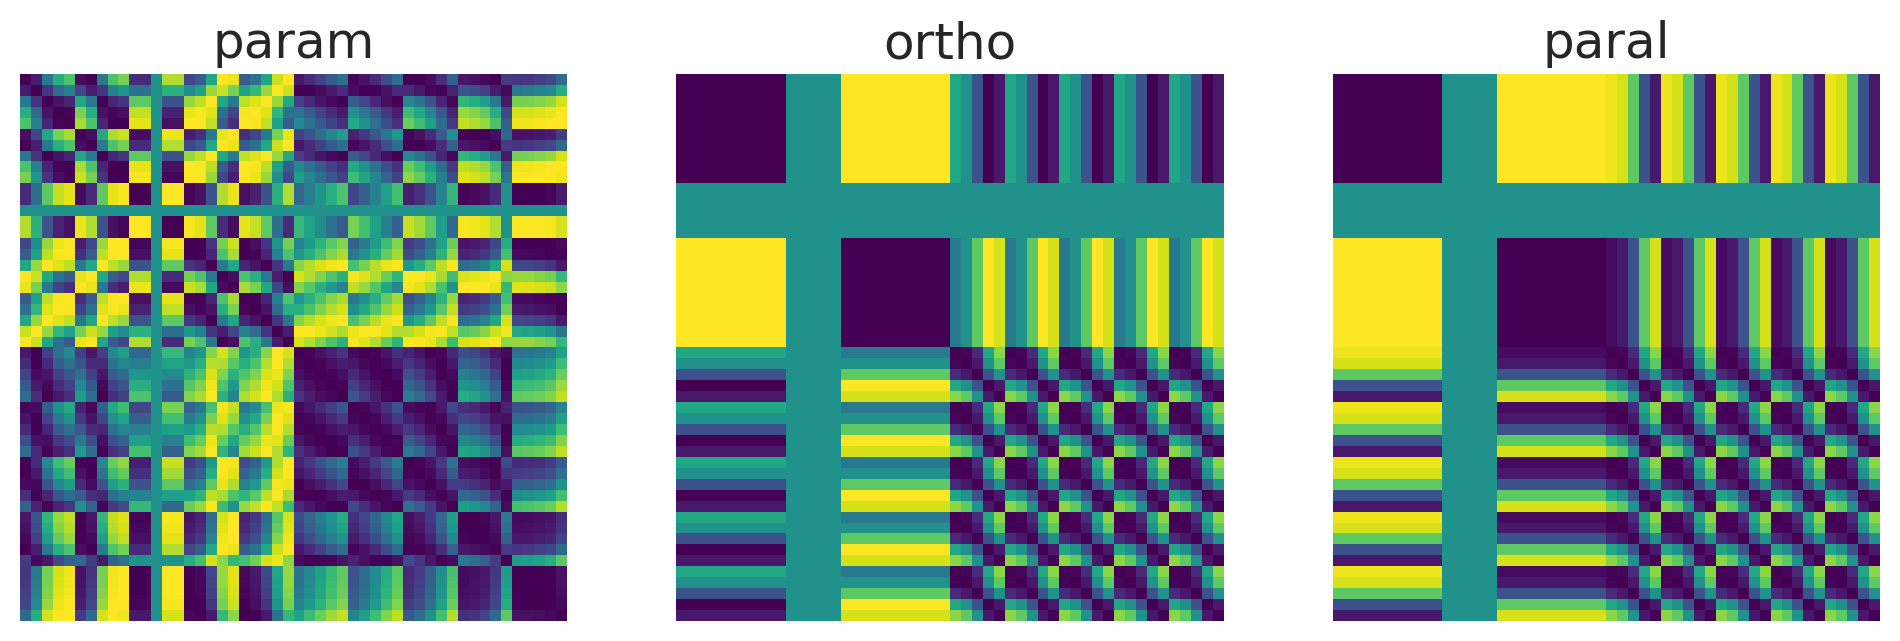

In [270]:
typ = 'grid'
rdms = {}
til = ['param', 'ortho', 'paral']
for typ in ['param', 'orth', 'parl']:
    x_bar = eval(f'x_{typ}') - eval(f'x_{typ}').mean(1, keepdims=True)
    rdm = np.zeros([50, 50])
    for i in range(x_bar.shape[0]):
        for j in range(x_bar.shape[0]):
            xi = x_bar[i, :]
            xj = x_bar[j, :]
            d = 1 - (xi@xj.T/np.sqrt(xi@xi.T*xj@xj.T+1e-12))
            rdm[i, j] = d
    rdms[typ] = rdm
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, typ in enumerate(rdms.keys()):
    ax = axs[i]
    sns.heatmap(rdms[typ].round(2), cmap='viridis', 
                vmin=0, vmax=2,
                cbar=None, ax=ax)
    ax.set_box_aspect(1)
    ax.set_title(f'{til[i]}')
    ax.set_axis_off()